Starting Hyperparameter Tuning for Solar Forecasting...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

BEST PARAMS: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': True}

TUNED MODEL PERFORMANCE:
RMSE: 67.05
R2 Score: 0.9535


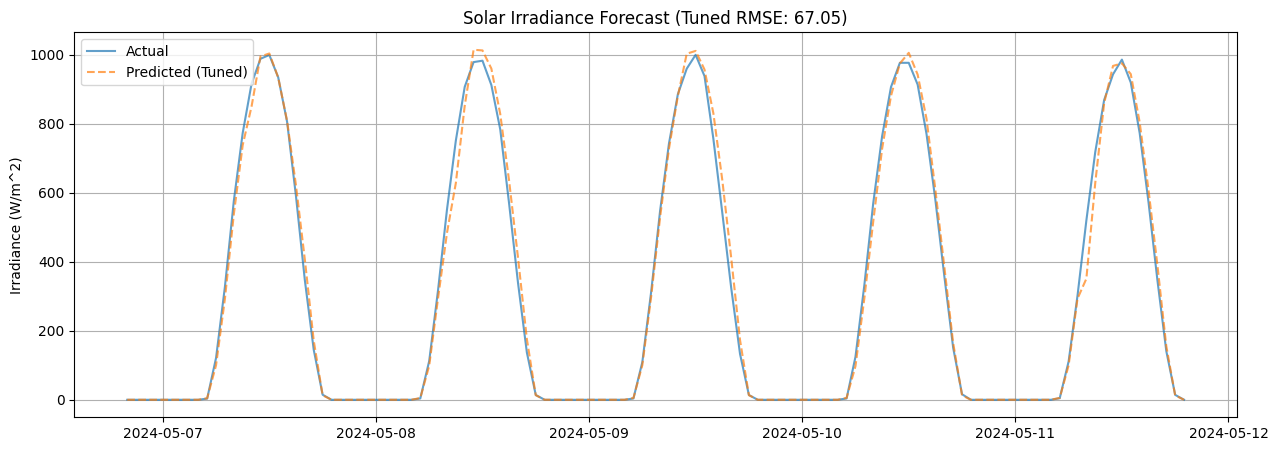

C:\Users\chara\AppData\Local\Temp\ipykernel_28308\3396848917.py:122: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


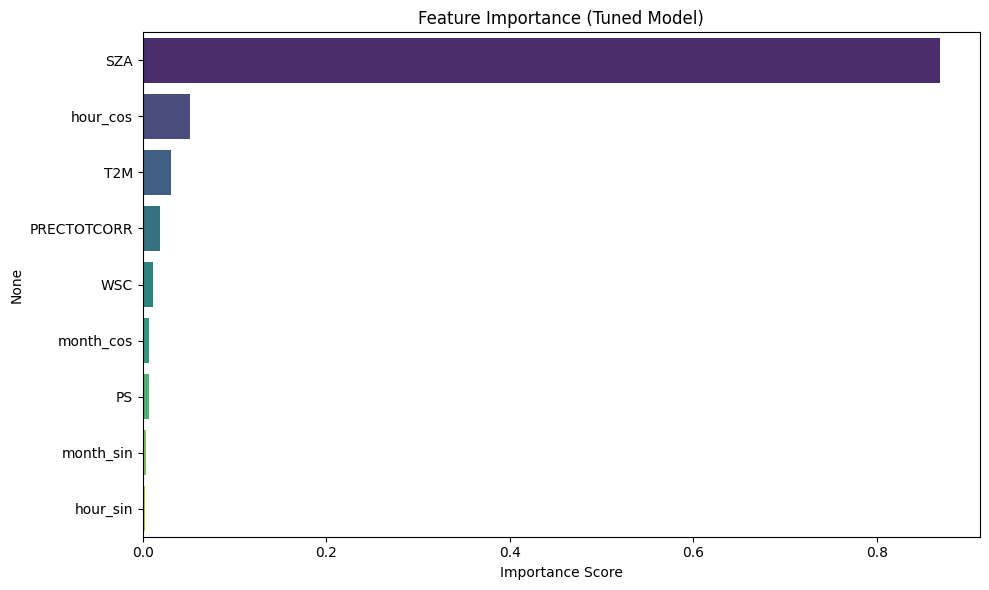


Feature Importance:
SZA            0.861844
hour_cos       0.050858
T2M            0.032368
PRECTOTCORR    0.019844
WSC            0.013459
PS             0.007902
month_cos      0.007334
month_sin      0.003588
hour_sin       0.002804
dtype: float64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ==========================================
# 1. Load and Clean Data
# ==========================================
try:
    df = pd.read_csv('Ahmedabad solar irradiance.csv')
except FileNotFoundError:
    df = pd.read_csv('../data/Ahmedabad solar irradiance.csv')

# Drop missing targets (-999.0)
df_clean = df[df['ALLSKY_SFC_SW_DWN'] != -999.0].copy()

# Drop 'ALLSKY_KT' (too many missing values)
df_clean = df_clean.drop(columns=['ALLSKY_KT'])

# Create Datetime Index
df_clean['Datetime'] = pd.to_datetime(df_clean[['YEAR', 'MO', 'DY', 'HR']].rename(
    columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}))
df_clean = df_clean.set_index('Datetime').sort_index()

# ==========================================
# 2. Feature Engineering
# ==========================================
# Cyclic encoding
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['HR'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['HR'] / 24)
df_clean['month_sin'] = np.sin(2 * np.pi * df_clean['MO'] / 12)
df_clean['month_cos'] = np.cos(2 * np.pi * df_clean['MO'] / 12)

# Select Features and Target
features = ['SZA', 'T2M', 'PS', 'WSC', 'PRECTOTCORR', 
            'hour_sin', 'hour_cos', 'month_sin', 'month_cos']
target = 'ALLSKY_SFC_SW_DWN'

X = df_clean[features]
y = df_clean[target]

# ==========================================
# 3. Time Series Split
# ==========================================
# Strict temporal split for final evaluation
split_point = int(len(df_clean) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

# ==========================================
# 4. Hyperparameter Tuning (Corrected for Windows)
# ==========================================
# Parameter Grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Cross-Validation Strategy
tscv = TimeSeriesSplit(n_splits=3)

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# Initialize Randomized Search
# CRITICAL FIX: Set n_jobs=1 to avoid the Windows multiprocessing crash
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10, 
    cv=tscv,   
    verbose=1,
    random_state=42,
    n_jobs=1,  # <--- CHANGED FROM -1 TO 1
    scoring='neg_root_mean_squared_error'
)

print("Starting Hyperparameter Tuning for Solar Forecasting...")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("\n" + "="*40)
print(f"BEST PARAMS: {random_search.best_params_}")
print("="*40)

# ==========================================
# 5. Evaluation
# ==========================================
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTUNED MODEL PERFORMANCE:")
print(f"RMSE: {rmse:.2f}")
print(f"R2 Score: {r2:.4f}")

# ==========================================
# 6. Visualization
# ==========================================
# Forecast Plot (First 5 days of Test Set)
plt.figure(figsize=(15, 5))
subset = 24 * 5 
plt.plot(y_test.index[:subset], y_test.values[:subset], label='Actual', alpha=0.7)
plt.plot(y_test.index[:subset], y_pred[:subset], label='Predicted (Tuned)', alpha=0.7, linestyle='--')
plt.title(f'Solar Irradiance Forecast (Tuned RMSE: {rmse:.2f})')
plt.ylabel('Irradiance (W/m^2)')
plt.legend()
plt.grid(True)
plt.savefig('tuned_forecast_plot.png')
plt.show()

# Feature Importance
importances = pd.Series(best_model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('Feature Importance (Tuned Model)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('tuned_solar_importance.png')
plt.show()

importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature Importance:")
print(importances)